# Graph and Map of Philadelphia Ward Change In Turnout

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn
import vincent
from vincent.marks import ValueRef

vincent.core.initialize_notebook()

## Load Election Data

**Load the 2012 Election Data**

In [2]:
results_2012 = pd.read_csv("../data/elections/2012_general.csv")

In [3]:
pres_2012 = results_2012[
                results_2012["OFFICE"] == "PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES"
            ].copy()
pres_2012["VOTES"] = pres_2012["VOTES"].fillna(0)

In [4]:
pres_2012_votes = pres_2012.groupby(["WARD", "PARTY"])["VOTES"].sum().unstack()

In [5]:
pres_2012_votes["total_votes"] = pres_2012_votes.sum(axis=1)

**Load the 2016 Election Data**

In [6]:
results_2016 = pd.read_csv("../data/elections/PRECINCT_20161111_H13_M51_S16.txt", sep="@")

In [7]:
def get_ward_division(precinct):
    try:
        pieces = precinct.split("-")
        return int(pieces[0]), int(pieces[1])
    except ValueError:
        return None, None

In [8]:
results_2016["WARD"], results_2016["DIVISION"] = zip(*results_2016["Precinct_Name"].apply(get_ward_division))

In [9]:
pres_2016 = results_2016[
                results_2016["Office_Prop Name"] == "PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES"
            ].copy()
pres_2016["Vote_Count"] = pres_2016["Vote_Count"].fillna(0)

In [10]:
pres_2016_votes = pres_2016.groupby(["WARD", "Party_Name"])["Vote_Count"].sum().unstack()

In [11]:
pres_2016_votes["total_votes"] = pres_2016_votes.sum(axis=1)

## Merge Election Data

In [12]:
votes_2012_vs_2016 = pres_2012_votes.join(pres_2016_votes, rsuffix="_2016", lsuffix="_2012")

In [13]:
votes_2012_vs_2016["total_turnout_pct_change"] = (votes_2012_vs_2016["total_votes_2016"] - \
                                                  votes_2012_vs_2016["total_votes_2012"]) \
                                                / votes_2012_vs_2016["total_votes_2012"] * 100

In [14]:
votes_2012_vs_2016 = votes_2012_vs_2016.reset_index()

In [15]:
votes_2012_vs_2016["ward_str"] = votes_2012_vs_2016["WARD"].astype(str)

In [16]:
votes_2012_vs_2016.head(3).T

,0,1,2
WARD,1,2,3
DEMOCRATIC_2012,5882,10324,10003
GREEN_2012,53,75,5
LIBERTARIAN_2012,61,97,6
REPUBLICAN_2012,1418,1914,57
total_votes_2012,7414,12410,10071
CONSTITUTION PARTY,18,11,7
DEMOCRATIC_2016,6529,11442,9001
GREEN_2016,148,152,54
LIBERTARIAN_2016,137,211,22


## Load Census Data

In [17]:
geo_data = pd.read_csv("../data/census/DEC_10_SF1_G001_with_ann.csv", skiprows=1,
                        dtype={"GEOGRAPHIC AREA CODES - Voting District": str})

In [18]:
geo_slice = geo_data[["Id", "Id2", "Geography", "GEOGRAPHIC AREA CODES - Voting District", 
         "GEOGRAPHIC AREA CODES - Voting District Indicator"]]

In [19]:
race_data = pd.read_csv("../data/census/DEC_10_SF1_P3_with_ann.csv", skiprows=1)

In [20]:
census = pd.merge(
    race_data,
    geo_slice,
    on="Id"
)

In [21]:
def split_ward_precinct(district_code):
    stripped_code = district_code.strip()
    if len(stripped_code) == 4:
        return stripped_code[0:2], stripped_code[2:4]
    elif len(stripped_code) == 3:
        return stripped_code[0], stripped_code[1:3]
    else:
        pass

In [22]:
census["ward"], census["district"] = zip(*census["GEOGRAPHIC AREA CODES - Voting District"].apply(split_ward_precinct))

## Analyze Race by Ward

In [23]:
race_by_ward = census.groupby("ward").sum()[["Total:","White alone","Black or African American alone",
                              "American Indian and Alaska Native alone","Asian alone",
                              "Native Hawaiian and Other Pacific Islander alone",
                              "Some Other Race alone","Two or More Races"]]

In [24]:
race_by_ward["pct_black"] = race_by_ward["Black or African American alone"] / race_by_ward["Total:"] * 100

In [25]:
race_by_ward.head(3)

,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,pct_black
ward,,,,,,,,,
1,18879,11376,1493,80,3688,1,1717,524,7.908258
10,25899,2388,22443,88,318,4,153,505,86.655855
11,23659,6003,13981,84,2755,8,339,489,59.093791


In [26]:
voting_with_race = votes_2012_vs_2016.set_index("ward_str").join(race_by_ward)

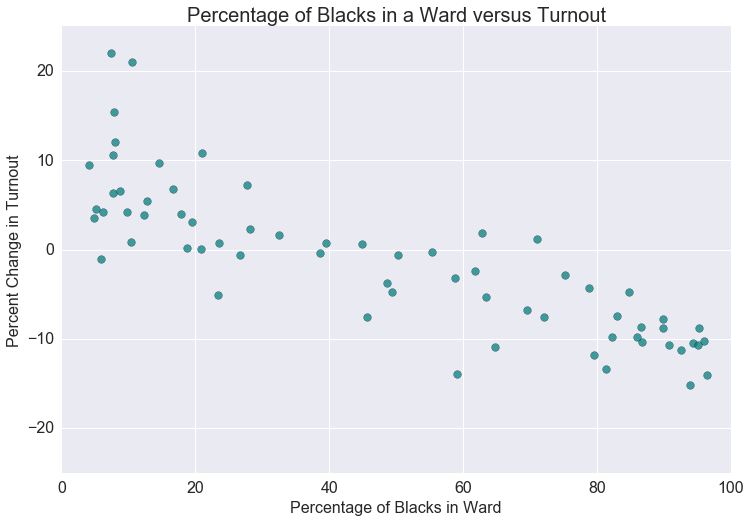

In [27]:
ax = voting_with_race.plot(kind="scatter", x="pct_black", y="total_turnout_pct_change", 
                           figsize=[12,8], s=60, fontsize=16, c="teal", edgecolors="black", alpha=0.75)
ax.set_title("Percentage of Blacks in a Ward versus Turnout", fontsize=20)
ax.set_xlim([0,100])
ax.set_ylim([-25,25])
ax.set_ylabel("Percent Change in Turnout", fontsize=16)
ax.set_xlabel("Percentage of Blacks in Ward", fontsize=16)
pass

In [28]:
voting_with_race[["pct_black", "total_turnout_pct_change"]].corr()

,pct_black,total_turnout_pct_change
pct_black,1.000000,-0.836576
total_turnout_pct_change,-0.836576,1.000000


## Map Turnout by Ward

In [29]:
ward_topo = "../data/maps/Political_Wards.json"

In [30]:
ward_map_data = [{'name': 'wards',
                 'url': ward_topo,
                 'feature': 'Political_Wards'}]

In [31]:
vis = vincent.Map(geo_data=ward_map_data, projection="albersUsa", scale=128000, translate=[-35750,7000],
                  data=votes_2012_vs_2016,
                  data_bind='total_turnout_pct_change', data_key='ward_str',
                  map_key={'wards': 'properties.WARD_NUM'}
                 )

vis.marks[0].properties.enter.stroke_opacity = ValueRef(value=0.5)
vis.rebind(column='total_turnout_pct_change', brew='PRGn')
vis.scales['color'].domain = [-25, -12.5, 0, 12.5, 25]

In [32]:
vis

---

---

---